# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-random'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(random_indices)
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.8278, F1 Micro: 0.0526, F1 Macro: 0.0182
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.8295, F1 Micro: 0.0347, F1 Macro: 0.0148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3802, Accuracy: 0.8324, F1 Micro: 0.0695, F1 Macro: 0.0281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8526, F1 Micro: 0.3213, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.342, Accuracy: 0.8673, F1 Micro: 0.4473, F1 Macro: 0.192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3115, Accuracy: 0.8739, F1 Micro: 0.6072, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.269, Accuracy: 0.8773, F1 Micro: 0.6207, F1 Macro: 0.3031
Epoch 8/10, Train Loss: 0.2578, Accuracy: 0.8806, F1 Micro: 0.5807, F1 Macro: 0.2899
Epoch 9/10, Train Loss: 0.2221, Accuracy: 0.8783, F1 Micro: 0.5331, F1 Macro: 0.2736
Epoch 10/10, Train Loss: 0.1966, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8309, F1 Micro: 0.0495, F1 Macro: 0.0209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.8687, F1 Micro: 0.4816, F1 Macro: 0.1983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3193, Accuracy: 0.8807, F1 Micro: 0.6348, F1 Macro: 0.3076
Epoch 4/10, Train Loss: 0.278, Accuracy: 0.8899, F1 Micro: 0.6255, F1 Macro: 0.3265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.23, Accuracy: 0.8951, F1 Micro: 0.6727, F1 Macro: 0.4041
Epoch 6/10, Train Loss: 0.1856, Accuracy: 0.8987, F1 Micro: 0.6695, F1 Macro: 0.446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1711, Accuracy: 0.9008, F1 Micro: 0.7064, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1529, Accuracy: 0.9024, F1 Micro: 0.7074, F1 Macro: 0.4752
Epoch 9/10, Train Loss: 0.1227, Accuracy: 0.9017, F1 Micro: 0.7055, F1 Macro: 0.4891
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4472, Accuracy: 0.8474, F1 Micro: 0.2603, F1 Macro: 0.0896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3325, Accuracy: 0.8844, F1 Micro: 0.5885, F1 Macro: 0.288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2707, Accuracy: 0.8956, F1 Micro: 0.6607, F1 Macro: 0.3925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2333, Accuracy: 0.9015, F1 Micro: 0.6892, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1962, Accuracy: 0.9058, F1 Micro: 0.6955, F1 Macro: 0.4978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9089, F1 Micro: 0.7339, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9107, F1 Micro: 0.7401, F1 Macro: 0.5746
Epoch 8/10, Train Loss: 0.1091, Accuracy: 0.9083, F1 Micro: 0.7361, F1 Macro: 0.5561
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9129, F1 Micro: 0.7373, F1 Macro: 0.581
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4267, Accuracy: 0.8678, F1 Micro: 0.4671, F1 Macro: 0.2007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3072, Accuracy: 0.893, F1 Micro: 0.673, F1 Macro: 0.3987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.9037, F1 Micro: 0.6857, F1 Macro: 0.472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9079, F1 Micro: 0.7266, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.9139, F1 Micro: 0.7304, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9129, F1 Micro: 0.7418, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9146, F1 Micro: 0.7448, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9147, F1 Micro: 0.753, F1 Macro: 0.6324
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9125, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4055, Accuracy: 0.8766, F1 Micro: 0.607, F1 Macro: 0.2907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.8979, F1 Micro: 0.6527, F1 Macro: 0.4394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.9076, F1 Micro: 0.7027, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9131, F1 Micro: 0.7257, F1 Macro: 0.5495
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.913, F1 Micro: 0.7141, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9164, F1 Micro: 0.7469, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9122, F1 Micro: 0.7501, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9175, F1 Micro: 0.7554, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.917, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.398, Accuracy: 0.8823, F1 Micro: 0.5992, F1 Macro: 0.3003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.901, F1 Micro: 0.6784, F1 Macro: 0.4761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9123, F1 Micro: 0.739, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9165, F1 Micro: 0.743, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9178, F1 Micro: 0.7544, F1 Macro: 0.6112
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9182, F1 Micro: 0.7502, F1 Macro: 0.6222
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9161, F1 Micro: 0.7524, F1 Macro: 0.6391
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.917, F1 Micro: 0.7613, F1 Macro: 0.6621
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9182, F1 Micro: 0.7416, F1 Macro: 0.6554
Epoch 10/10, Train Loss: 0.0556, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8819, F1 Micro: 0.5621, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.9054, F1 Micro: 0.7043, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9122, F1 Micro: 0.7249, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9151, F1 Micro: 0.7526, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.916, F1 Micro: 0.7547, F1 Macro: 0.6124
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9173, F1 Micro: 0.7469, F1 Macro: 0.6273
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.92, F1 Micro: 0.7647, F1 Macro: 0.6471
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9168, F1 Micro: 0.7624, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9226, F1 Micro: 0.7685, F1 Macro: 0.6828
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8873, F1 Micro: 0.6478, F1 Macro: 0.316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9072, F1 Micro: 0.7263, F1 Macro: 0.5195
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.9173, F1 Micro: 0.7395, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.9194, F1 Micro: 0.7527, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9209, F1 Micro: 0.7586, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9228, F1 Micro: 0.7703, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9224, F1 Micro: 0.7717, F1 Macro: 0.6658
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9201, F1 Micro: 0.7716, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9227, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8899, F1 Micro: 0.6309, F1 Macro: 0.3237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9104, F1 Micro: 0.715, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9163, F1 Micro: 0.7253, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9206, F1 Micro: 0.7651, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9226, F1 Micro: 0.7653, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9209, F1 Micro: 0.7722, F1 Macro: 0.6576
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9243, F1 Micro: 0.769, F1 Macro: 0.6699
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9236, F1 Micro: 0.772, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9217, F1 Micro: 0.7693, F1 Macro: 0.6971
Epoch 10/10, Train Loss: 0.0476, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3686, Accuracy: 0.8917, F1 Micro: 0.6334, F1 Macro: 0.3534
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9064, F1 Micro: 0.7272, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.913, F1 Micro: 0.7373, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9218, F1 Micro: 0.7644, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9204, F1 Micro: 0.7707, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9239, F1 Micro: 0.7787, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9221, F1 Micro: 0.7741, F1 Macro: 0.6747
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9221, F1 Micro: 0.7765, F1 Macro: 0.6976
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9215, F1 Micro: 0.7773, F1 Macro: 0.693
Epoch 10/10, Train Loss: 0.0489, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8901, F1 Micro: 0.6, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9116, F1 Micro: 0.741, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9138, F1 Micro: 0.7633, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9225, F1 Micro: 0.776, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9249, F1 Micro: 0.7808, F1 Macro: 0.6912
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9259, F1 Micro: 0.7754, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.924, F1 Micro: 0.7824, F1 Macro: 0.6987
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9214, F1 Micro: 0.7694, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9269, F1 Micro: 0.7804, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3574, Accuracy: 0.8979, F1 Micro: 0.6712, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.9101, F1 Micro: 0.7153, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9196, F1 Micro: 0.7641, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9238, F1 Micro: 0.7697, F1 Macro: 0.6428
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9202, F1 Micro: 0.7675, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9245, F1 Micro: 0.7755, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.923, F1 Micro: 0.7763, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9261, F1 Micro: 0.7842, F1 Macro: 0.7151
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9222, F1 Micro: 0.7719, F1 Macro: 0.7021
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.357, Accuracy: 0.8935, F1 Micro: 0.6159, F1 Macro: 0.3671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9156, F1 Micro: 0.7425, F1 Macro: 0.5452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9206, F1 Micro: 0.7538, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9266, F1 Micro: 0.7764, F1 Macro: 0.6513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9261, F1 Micro: 0.7773, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.924, F1 Micro: 0.7795, F1 Macro: 0.6806
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9255, F1 Micro: 0.7713, F1 Macro: 0.6996
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9207, F1 Micro: 0.7711, F1 Macro: 0.7058
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9253, F1 Micro: 0.7754, F1 Macro: 0.7102
Epoch 10/10, Train Loss: 0.0446, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3508, Accuracy: 0.8968, F1 Micro: 0.6517, F1 Macro: 0.3703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.9134, F1 Micro: 0.7484, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9228, F1 Micro: 0.7572, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9229, F1 Micro: 0.7758, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9218, F1 Micro: 0.7814, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9257, F1 Micro: 0.7848, F1 Macro: 0.7006
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9248, F1 Micro: 0.7794, F1 Macro: 0.6953
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9234, F1 Micro: 0.78, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9273, F1 Micro: 0.7892, F1 Macro: 0.7229
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.8974, F1 Micro: 0.6411, F1 Macro: 0.3775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9136, F1 Micro: 0.7293, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.9227, F1 Micro: 0.7651, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9236, F1 Micro: 0.776, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9273, F1 Micro: 0.7789, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9284, F1 Micro: 0.7859, F1 Macro: 0.6974
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9222, F1 Micro: 0.7805, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.927, F1 Micro: 0.7879, F1 Macro: 0.7168
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.928, F1 Micro: 0.7837, F1 Macro: 0.7131
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.347, Accuracy: 0.8974, F1 Micro: 0.6803, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.9103, F1 Micro: 0.7292, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9256, F1 Micro: 0.77, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9266, F1 Micro: 0.7715, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9262, F1 Micro: 0.7782, F1 Macro: 0.6781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9257, F1 Micro: 0.781, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9278, F1 Micro: 0.7869, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9235, F1 Micro: 0.7814, F1 Macro: 0.7081
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9269, F1 Micro: 0.7862, F1 Macro: 0.7147
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3468, Accuracy: 0.899, F1 Micro: 0.7022, F1 Macro: 0.4707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.9164, F1 Micro: 0.739, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9212, F1 Micro: 0.7728, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9247, F1 Micro: 0.7768, F1 Macro: 0.6444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.925, F1 Micro: 0.784, F1 Macro: 0.6824
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9265, F1 Micro: 0.7817, F1 Macro: 0.6911
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9249, F1 Micro: 0.7803, F1 Macro: 0.6999
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9279, F1 Micro: 0.7882, F1 Macro: 0.7184
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9263, F1 Micro: 0.7855, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0469, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.346, Accuracy: 0.8983, F1 Micro: 0.6407, F1 Macro: 0.3907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.9143, F1 Micro: 0.7539, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9249, F1 Micro: 0.7736, F1 Macro: 0.6399
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9224, F1 Micro: 0.7665, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9266, F1 Micro: 0.7791, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9282, F1 Micro: 0.7857, F1 Macro: 0.6966
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.928, F1 Micro: 0.7828, F1 Macro: 0.6947
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.925, F1 Micro: 0.7839, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9297, F1 Micro: 0.7869, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0453, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.34, Accuracy: 0.9015, F1 Micro: 0.7107, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9194, F1 Micro: 0.7556, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9154, F1 Micro: 0.763, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9234, F1 Micro: 0.7751, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9252, F1 Micro: 0.7769, F1 Macro: 0.686
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9207, F1 Micro: 0.7747, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9276, F1 Micro: 0.7781, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9279, F1 Micro: 0.7855, F1 Macro: 0.7137
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9251, F1 Micro: 0.7823, F1 Macro: 0.7157
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.9032, F1 Micro: 0.6894, F1 Macro: 0.4791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9193, F1 Micro: 0.7535, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9262, F1 Micro: 0.7781, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9266, F1 Micro: 0.7855, F1 Macro: 0.6558
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9274, F1 Micro: 0.785, F1 Macro: 0.6828
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9272, F1 Micro: 0.7846, F1 Macro: 0.7097
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9271, F1 Micro: 0.7834, F1 Macro: 0.7096
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.924, F1 Micro: 0.7831, F1 Macro: 0.7165
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9248, F1 Micro: 0.7831, F1 Macro: 0.7231
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9236, F1 Micro: 0.7784, F1 Macro: 0.7198

 Iteration 9216: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.338, Accuracy: 0.8978, F1 Micro: 0.6363, F1 Macro: 0.4079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2231, Accuracy: 0.9178, F1 Micro: 0.7566, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9176, F1 Micro: 0.7699, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9221, F1 Micro: 0.7758, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9292, F1 Micro: 0.7866, F1 Macro: 0.6705
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9265, F1 Micro: 0.7851, F1 Macro: 0.6884
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9254, F1 Micro: 0.7857, F1 Macro: 0.7104
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9262, F1 Micro: 0.7859, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9271, F1 Micro: 0.781, F1 Macro: 0.7168
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9286, F1 Micro: 0.7845, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3407, Accuracy: 0.9037, F1 Micro: 0.7097, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9197, F1 Micro: 0.7657, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9248, F1 Micro: 0.77, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9267, F1 Micro: 0.7895, F1 Macro: 0.6979
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9254, F1 Micro: 0.784, F1 Macro: 0.6941
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9279, F1 Micro: 0.7811, F1 Macro: 0.6971
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9256, F1 Micro: 0.7847, F1 Macro: 0.7042
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9278, F1 Micro: 0.7837, F1 Macro: 0.7181
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9257, F1 Micro: 0.7894, F1 Macro: 0.7228
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9252, F1 Micro: 0.7827, F1 Macro: 0.7203

 Iteration 9418: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3334, Accuracy: 0.9023, F1 Micro: 0.6717, F1 Macro: 0.441
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.92, F1 Micro: 0.7499, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9272, F1 Micro: 0.7794, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9247, F1 Micro: 0.7815, F1 Macro: 0.6755
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9276, F1 Micro: 0.7788, F1 Macro: 0.6725
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9272, F1 Micro: 0.7792, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9275, F1 Micro: 0.7869, F1 Macro: 0.7115
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9242, F1 Micro: 0.7796, F1 Macro: 0.7103
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9243, F1 Micro: 0.7862, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9216, F1 Micro: 0.7806, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3321, Accuracy: 0.9054, F1 Micro: 0.6981, F1 Macro: 0.5055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2212, Accuracy: 0.918, F1 Micro: 0.7583, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9251, F1 Micro: 0.7716, F1 Macro: 0.6276
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9235, F1 Micro: 0.7649, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9268, F1 Micro: 0.7828, F1 Macro: 0.6672
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9279, F1 Micro: 0.7821, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9256, F1 Micro: 0.7874, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9257, F1 Micro: 0.7877, F1 Macro: 0.7202
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9271, F1 Micro: 0.7869, F1 Macro: 0.7192
Epoch 10/10, Train Loss: 0.0401, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3325, Accuracy: 0.9056, F1 Micro: 0.719, F1 Macro: 0.5171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9197, F1 Micro: 0.7587, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9249, F1 Micro: 0.7795, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9286, F1 Micro: 0.7944, F1 Macro: 0.6854
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9293, F1 Micro: 0.7902, F1 Macro: 0.711
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9231, F1 Micro: 0.78, F1 Macro: 0.6966
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9253, F1 Micro: 0.7768, F1 Macro: 0.6945
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.928, F1 Micro: 0.7857, F1 Macro: 0.7227
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9282, F1 Micro: 0.789, F1 Macro: 0.7194
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9263, F1 Micro: 0.7875, F1 Macro: 0.7138

 Iteration 10018: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3275, Accuracy: 0.9068, F1 Micro: 0.7119, F1 Macro: 0.4936
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9194, F1 Micro: 0.7634, F1 Macro: 0.5831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1731, Accuracy: 0.9254, F1 Micro: 0.7785, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9275, F1 Micro: 0.7836, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9266, F1 Micro: 0.7864, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9283, F1 Micro: 0.7895, F1 Macro: 0.7169
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9281, F1 Micro: 0.7851, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.929, F1 Micro: 0.7914, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9291, F1 Micro: 0.7883, F1 Macro: 0.7208
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9059, F1 Micro: 0.6905, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9188, F1 Micro: 0.736, F1 Macro: 0.5707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9266, F1 Micro: 0.773, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9286, F1 Micro: 0.7865, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9279, F1 Micro: 0.7899, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9281, F1 Micro: 0.7923, F1 Macro: 0.7132
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9282, F1 Micro: 0.7923, F1 Macro: 0.7199
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9284, F1 Micro: 0.785, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9294, F1 Micro: 0.796, F1 Macro: 0.7337
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.9004, F1 Micro: 0.6676, F1 Macro: 0.4012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9177, F1 Micro: 0.7645, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9247, F1 Micro: 0.7812, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9278, F1 Micro: 0.7871, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.929, F1 Micro: 0.7896, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.929, F1 Micro: 0.794, F1 Macro: 0.7156
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9262, F1 Micro: 0.7903, F1 Macro: 0.7228
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9287, F1 Micro: 0.7911, F1 Macro: 0.727
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9295, F1 Micro: 0.792, F1 Macro: 0.7254
Epoch 10/10, Train Loss: 0.0421, Accuracy:

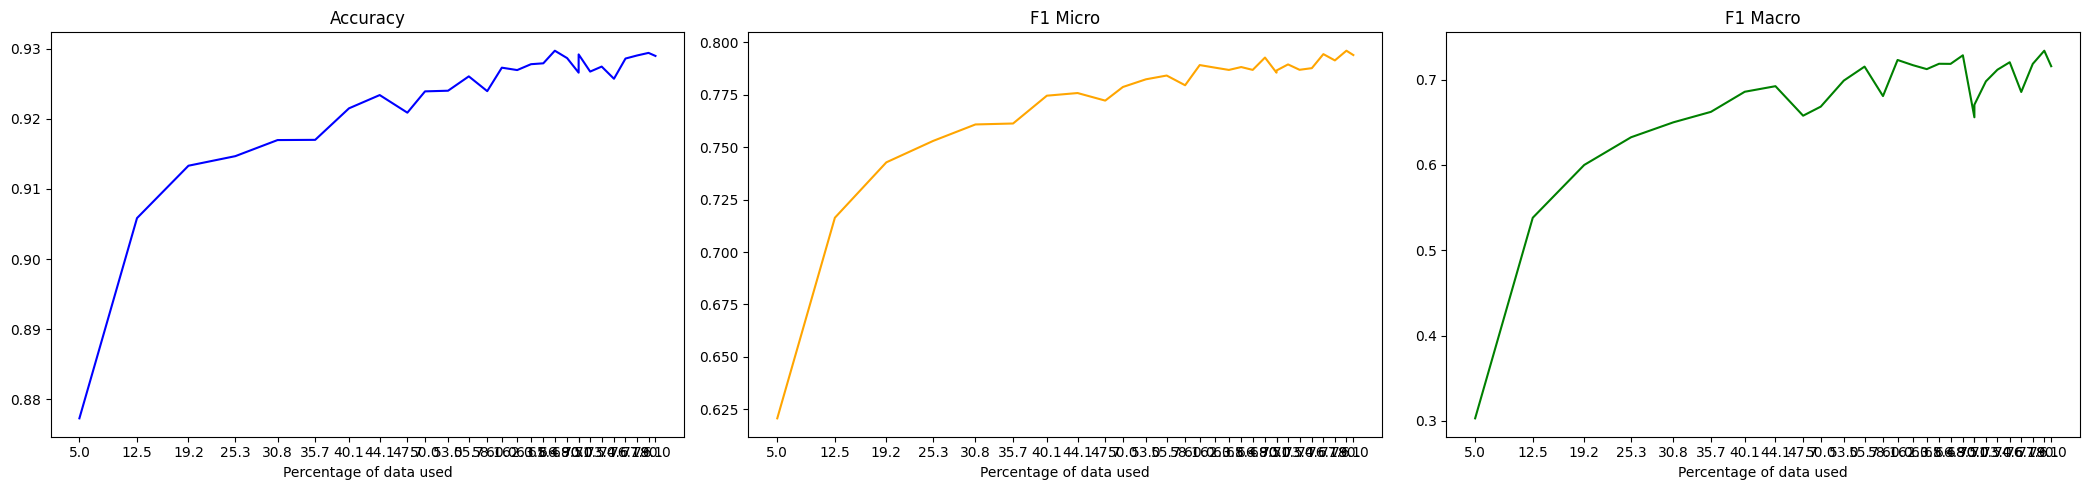

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5266, Accuracy: 0.8301, F1 Micro: 0.2891, F1 Macro: 0.0662
Epoch 2/10, Train Loss: 0.3942, Accuracy: 0.8359, F1 Micro: 0.1442, F1 Macro: 0.0503
Epoch 3/10, Train Loss: 0.3671, Accuracy: 0.8486, F1 Micro: 0.2855, F1 Macro: 0.1017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3413, Accuracy: 0.867, F1 Micro: 0.4893, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3096, Accuracy: 0.8779, F1 Micro: 0.5722, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2733, Accuracy: 0.8816, F1 Micro: 0.5875, F1 Macro: 0.2778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2475, Accuracy: 0.8853, F1 Micro: 0.601, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2294, Accuracy: 0.888, F1 Micro: 0.6436, F1 Macro: 0.3443
Epoch 9/10, Train Loss: 0.198, Accuracy: 0.8897, F1 Micro: 0.6336, F1 Macro: 0.3385
Epoch 10/10, Train Loss: 0.1811, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4612, Accuracy: 0.8364, F1 Micro: 0.1454, F1 Macro: 0.0508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3624, Accuracy: 0.8747, F1 Micro: 0.537, F1 Macro: 0.2483
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3071, Accuracy: 0.8829, F1 Micro: 0.6338, F1 Macro: 0.3055
Epoch 4/10, Train Loss: 0.2572, Accuracy: 0.8858, F1 Micro: 0.5644, F1 Macro: 0.2929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2239, Accuracy: 0.8982, F1 Micro: 0.6599, F1 Macro: 0.3998
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1954, Accuracy: 0.9054, F1 Micro: 0.6994, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1696, Accuracy: 0.9071, F1 Micro: 0.7012, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1413, Accuracy: 0.9063, F1 Micro: 0.7109, F1 Macro: 0.506
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1196, Accuracy: 0.909, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8511, F1 Micro: 0.3261, F1 Macro: 0.1056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3248, Accuracy: 0.8847, F1 Micro: 0.5794, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2629, Accuracy: 0.8951, F1 Micro: 0.677, F1 Macro: 0.3791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2252, Accuracy: 0.9045, F1 Micro: 0.7081, F1 Macro: 0.4656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.186, Accuracy: 0.9097, F1 Micro: 0.7164, F1 Macro: 0.5
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9085, F1 Micro: 0.7108, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.9126, F1 Micro: 0.7475, F1 Macro: 0.5879
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.908, F1 Micro: 0.7389, F1 Macro: 0.5672
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.912, F1 Micro: 0.7302, F1 Macro: 0.5668
Epoch 10/10, Train Loss: 0.0804, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4058, Accuracy: 0.8714, F1 Micro: 0.491, F1 Macro: 0.2197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2953, Accuracy: 0.8945, F1 Micro: 0.6371, F1 Macro: 0.3638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2395, Accuracy: 0.9055, F1 Micro: 0.6954, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9092, F1 Micro: 0.7306, F1 Macro: 0.5195
Epoch 5/10, Train Loss: 0.1638, Accuracy: 0.9133, F1 Micro: 0.7263, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9149, F1 Micro: 0.7406, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1134, Accuracy: 0.9174, F1 Micro: 0.7483, F1 Macro: 0.5907
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.9116, F1 Micro: 0.7483, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9153, F1 Micro: 0.7484, F1 Macro: 0.6058
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8812, F1 Micro: 0.6129, F1 Macro: 0.2857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.8989, F1 Micro: 0.6901, F1 Macro: 0.4114
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9071, F1 Micro: 0.682, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9153, F1 Micro: 0.7431, F1 Macro: 0.5531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9192, F1 Micro: 0.745, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9207, F1 Micro: 0.7616, F1 Macro: 0.6022
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9199, F1 Micro: 0.7629, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.918, F1 Micro: 0.7644, F1 Macro: 0.6237
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9195, F1 Micro: 0.7571, F1 Macro: 0.6396
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3843, Accuracy: 0.8829, F1 Micro: 0.6297, F1 Macro: 0.3035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2602, Accuracy: 0.9044, F1 Micro: 0.6905, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9111, F1 Micro: 0.7367, F1 Macro: 0.5306
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9149, F1 Micro: 0.7296, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9191, F1 Micro: 0.7542, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.915, F1 Micro: 0.7554, F1 Macro: 0.5923
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9157, F1 Micro: 0.7471, F1 Macro: 0.5976
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9145, F1 Micro: 0.7486, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9169, F1 Micro: 0.7623, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8818, F1 Micro: 0.5494, F1 Macro: 0.2646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2563, Accuracy: 0.9072, F1 Micro: 0.6971, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9164, F1 Micro: 0.7478, F1 Macro: 0.5663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9205, F1 Micro: 0.7524, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9208, F1 Micro: 0.7582, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9209, F1 Micro: 0.7599, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9171, F1 Micro: 0.7606, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9222, F1 Micro: 0.7693, F1 Macro: 0.6624
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9226, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.8924, F1 Micro: 0.6662, F1 Macro: 0.3677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9104, F1 Micro: 0.713, F1 Macro: 0.5057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9171, F1 Micro: 0.7554, F1 Macro: 0.5789
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.918, F1 Micro: 0.7473, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.918, F1 Micro: 0.7633, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9208, F1 Micro: 0.772, F1 Macro: 0.6413
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9214, F1 Micro: 0.7634, F1 Macro: 0.6378
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9222, F1 Micro: 0.7622, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.917, F1 Micro: 0.7684, F1 Macro: 0.6463
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.9221, F1 Micro: 0.767, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.8872, F1 Micro: 0.5886, F1 Macro: 0.3067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9106, F1 Micro: 0.7374, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9163, F1 Micro: 0.7426, F1 Macro: 0.5388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9217, F1 Micro: 0.7683, F1 Macro: 0.6072
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9166, F1 Micro: 0.7596, F1 Macro: 0.6062
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.9219, F1 Micro: 0.761, F1 Macro: 0.6263
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9203, F1 Micro: 0.7663, F1 Macro: 0.6267
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9214, F1 Micro: 0.7618, F1 Macro: 0.6438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9221, F1 Micro: 0.7735, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0483, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.8955, F1 Micro: 0.6634, F1 Macro: 0.3488
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.912, F1 Micro: 0.7367, F1 Macro: 0.5527
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1946, Accuracy: 0.9192, F1 Micro: 0.7586, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9194, F1 Micro: 0.7661, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9246, F1 Micro: 0.769, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9207, F1 Micro: 0.769, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.925, F1 Micro: 0.771, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9176, F1 Micro: 0.7726, F1 Macro: 0.6712
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9233, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3504, Accuracy: 0.8952, F1 Micro: 0.6795, F1 Macro: 0.3819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.914, F1 Micro: 0.7309, F1 Macro: 0.5275
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9209, F1 Micro: 0.7556, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9236, F1 Micro: 0.7666, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.925, F1 Micro: 0.7782, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.924, F1 Micro: 0.7805, F1 Macro: 0.6636
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9211, F1 Micro: 0.7673, F1 Macro: 0.6527
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.924, F1 Micro: 0.7632, F1 Macro: 0.6758
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.925, F1 Micro: 0.7732, F1 Macro: 0.6839
Epoch 10/10, Train Loss: 0.0459, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3467, Accuracy: 0.8996, F1 Micro: 0.6921, F1 Macro: 0.4199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9139, F1 Micro: 0.741, F1 Macro: 0.5618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9153, F1 Micro: 0.7615, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9218, F1 Micro: 0.771, F1 Macro: 0.6234
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9206, F1 Micro: 0.7755, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9226, F1 Micro: 0.7772, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9248, F1 Micro: 0.7729, F1 Macro: 0.6503
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9251, F1 Micro: 0.7737, F1 Macro: 0.6594
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9254, F1 Micro: 0.7745, F1 Macro: 0.6825
Epoch 10/10, Train Loss: 0.0475, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8994, F1 Micro: 0.6762, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9155, F1 Micro: 0.7402, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1858, Accuracy: 0.9215, F1 Micro: 0.7559, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9251, F1 Micro: 0.7795, F1 Macro: 0.6325
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9248, F1 Micro: 0.7712, F1 Macro: 0.6441
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9262, F1 Micro: 0.7789, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9249, F1 Micro: 0.7797, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9262, F1 Micro: 0.7844, F1 Macro: 0.689
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9227, F1 Micro: 0.7821, F1 Macro: 0.7014
Epoch 10/10, Train Loss: 0.0456, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.8994, F1 Micro: 0.6822, F1 Macro: 0.3824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.9164, F1 Micro: 0.7502, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9232, F1 Micro: 0.7717, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9229, F1 Micro: 0.7751, F1 Macro: 0.6371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9253, F1 Micro: 0.7752, F1 Macro: 0.6591
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9209, F1 Micro: 0.7742, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9232, F1 Micro: 0.7795, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9251, F1 Micro: 0.7827, F1 Macro: 0.6864
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9207, F1 Micro: 0.7757, F1 Macro: 0.6898
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3457, Accuracy: 0.8984, F1 Micro: 0.6419, F1 Macro: 0.3676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9164, F1 Micro: 0.7491, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9227, F1 Micro: 0.7663, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9228, F1 Micro: 0.7698, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9258, F1 Micro: 0.7766, F1 Macro: 0.6572
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9243, F1 Micro: 0.7674, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9234, F1 Micro: 0.7799, F1 Macro: 0.6963
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.924, F1 Micro: 0.7765, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.9016, F1 Micro: 0.6965, F1 Macro: 0.4191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2239, Accuracy: 0.9154, F1 Micro: 0.7349, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9222, F1 Micro: 0.7729, F1 Macro: 0.6205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1404, Accuracy: 0.9248, F1 Micro: 0.7841, F1 Macro: 0.6458
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9258, F1 Micro: 0.7679, F1 Macro: 0.646
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9218, F1 Micro: 0.7741, F1 Macro: 0.6598
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9264, F1 Micro: 0.7839, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.922, F1 Micro: 0.7747, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9239, F1 Micro: 0.7769, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.047, Accuracy: 0.9262, F1 Micro: 0.7845, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3357, Accuracy: 0.9009, F1 Micro: 0.6953, F1 Macro: 0.4102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9168, F1 Micro: 0.7359, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.9201, F1 Micro: 0.7541, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9211, F1 Micro: 0.7722, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9252, F1 Micro: 0.7752, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9244, F1 Micro: 0.7815, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9242, F1 Micro: 0.7838, F1 Macro: 0.6814
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9207, F1 Micro: 0.7782, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9271, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.9007, F1 Micro: 0.6572, F1 Macro: 0.3966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.9188, F1 Micro: 0.755, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9241, F1 Micro: 0.7713, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9254, F1 Micro: 0.7836, F1 Macro: 0.6519
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9231, F1 Micro: 0.7811, F1 Macro: 0.6505
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9254, F1 Micro: 0.779, F1 Macro: 0.6782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9248, F1 Micro: 0.786, F1 Macro: 0.6947
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9268, F1 Micro: 0.7847, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9278, F1 Micro: 0.7889, F1 Macro: 0.7052
Epoch 10/10, Train Loss: 0.0444, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.9049, F1 Micro: 0.6975, F1 Macro: 0.4324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9168, F1 Micro: 0.744, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9236, F1 Micro: 0.7686, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9255, F1 Micro: 0.7782, F1 Macro: 0.6431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9247, F1 Micro: 0.78, F1 Macro: 0.6504
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9245, F1 Micro: 0.7798, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9258, F1 Micro: 0.7871, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9268, F1 Micro: 0.7877, F1 Macro: 0.7089
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9265, F1 Micro: 0.7839, F1 Macro: 0.713
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3304, Accuracy: 0.9043, F1 Micro: 0.7077, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.9174, F1 Micro: 0.736, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9244, F1 Micro: 0.7681, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9231, F1 Micro: 0.7761, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9268, F1 Micro: 0.7777, F1 Macro: 0.6554
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9228, F1 Micro: 0.7772, F1 Macro: 0.6843
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9244, F1 Micro: 0.7805, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9257, F1 Micro: 0.7833, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9244, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.9038, F1 Micro: 0.7046, F1 Macro: 0.444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9172, F1 Micro: 0.7371, F1 Macro: 0.5424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9244, F1 Micro: 0.771, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9218, F1 Micro: 0.7771, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9247, F1 Micro: 0.7835, F1 Macro: 0.676
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9259, F1 Micro: 0.7833, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9256, F1 Micro: 0.7856, F1 Macro: 0.709
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9255, F1 Micro: 0.7813, F1 Macro: 0.6945
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9255, F1 Micro: 0.7835, F1 Macro: 0.7127
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3259, Accuracy: 0.9074, F1 Micro: 0.7023, F1 Macro: 0.477
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.915, F1 Micro: 0.7259, F1 Macro: 0.5309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9236, F1 Micro: 0.7701, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.9259, F1 Micro: 0.7835, F1 Macro: 0.6557
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.926, F1 Micro: 0.7826, F1 Macro: 0.6594
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9266, F1 Micro: 0.7818, F1 Macro: 0.6646
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9271, F1 Micro: 0.7806, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9278, F1 Micro: 0.788, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9271, F1 Micro: 0.7886, F1 Macro: 0.7189
Epoch 10/10, Train Loss: 0.0417, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3322, Accuracy: 0.9008, F1 Micro: 0.6634, F1 Macro: 0.4299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.919, F1 Micro: 0.7538, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9252, F1 Micro: 0.7757, F1 Macro: 0.6347
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9271, F1 Micro: 0.7722, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9263, F1 Micro: 0.7803, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.925, F1 Micro: 0.7822, F1 Macro: 0.6965
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9233, F1 Micro: 0.7815, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9284, F1 Micro: 0.7929, F1 Macro: 0.7188
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9256, F1 Micro: 0.7897, F1 Macro: 0.7247
Epoch 10/10, Train Loss: 0.0414, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3329, Accuracy: 0.9027, F1 Micro: 0.7077, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9134, F1 Micro: 0.758, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9248, F1 Micro: 0.7721, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9251, F1 Micro: 0.7771, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1096, Accuracy: 0.9254, F1 Micro: 0.7776, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9265, F1 Micro: 0.7874, F1 Macro: 0.6949
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9255, F1 Micro: 0.7836, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9257, F1 Micro: 0.7844, F1 Macro: 0.7122
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9244, F1 Micro: 0.7818, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3258, Accuracy: 0.9019, F1 Micro: 0.6526, F1 Macro: 0.4267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9205, F1 Micro: 0.7545, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9236, F1 Micro: 0.777, F1 Macro: 0.6213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9287, F1 Micro: 0.7943, F1 Macro: 0.6862
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9255, F1 Micro: 0.7659, F1 Macro: 0.6435
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9242, F1 Micro: 0.783, F1 Macro: 0.6965
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.927, F1 Micro: 0.7887, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9268, F1 Micro: 0.7923, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9271, F1 Micro: 0.7858, F1 Macro: 0.7203
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.9279, F1 Micro: 0.7875, F1 Macro: 0.7243

 Iteration 10018: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9027, F1 Micro: 0.7253, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9169, F1 Micro: 0.7605, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9261, F1 Micro: 0.7801, F1 Macro: 0.6293
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9269, F1 Micro: 0.7781, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.927, F1 Micro: 0.7854, F1 Macro: 0.663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.9295, F1 Micro: 0.791, F1 Macro: 0.6948
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9281, F1 Micro: 0.7844, F1 Macro: 0.7091
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9259, F1 Micro: 0.7882, F1 Macro: 0.716
Epoch 9/10, Train Loss: 0.0473, Accuracy: 0.9247, F1 Micro: 0.7842, F1 Macro: 0.7169
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9282, F1 Micro: 0.7865, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.9082, F1 Micro: 0.7121, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9202, F1 Micro: 0.7648, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1737, Accuracy: 0.926, F1 Micro: 0.7852, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.929, F1 Micro: 0.787, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.928, F1 Micro: 0.7757, F1 Macro: 0.6429
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9255, F1 Micro: 0.789, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9301, F1 Micro: 0.7947, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9302, F1 Micro: 0.7855, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9279, F1 Micro: 0.7866, F1 Macro: 0.7168
Epoch 10/10, Train Loss: 0.0419, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3222, Accuracy: 0.9083, F1 Micro: 0.7091, F1 Macro: 0.4799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9126, F1 Micro: 0.7555, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9277, F1 Micro: 0.7789, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9274, F1 Micro: 0.7847, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9293, F1 Micro: 0.7856, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9284, F1 Micro: 0.7938, F1 Macro: 0.7047
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9259, F1 Micro: 0.7913, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9271, F1 Micro: 0.7812, F1 Macro: 0.712
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9278, F1 Micro: 0.784, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.0397, Accurac

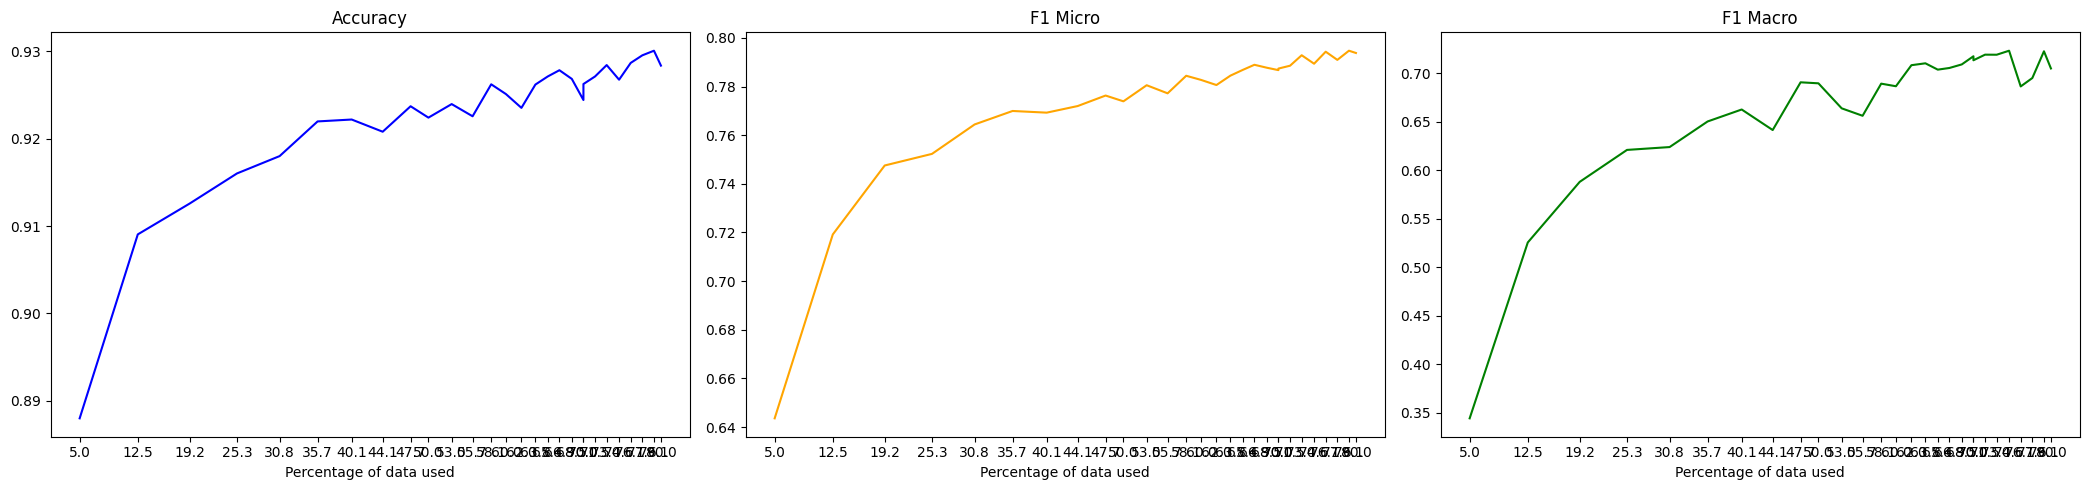

In [24]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5457, Accuracy: 0.8292, F1 Micro: 0.0597, F1 Macro: 0.0209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.8424, F1 Micro: 0.221, F1 Macro: 0.0713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3893, Accuracy: 0.8443, F1 Micro: 0.2286, F1 Macro: 0.0808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3533, Accuracy: 0.8603, F1 Micro: 0.4071, F1 Macro: 0.157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3123, Accuracy: 0.8733, F1 Micro: 0.5274, F1 Macro: 0.2581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2824, Accuracy: 0.8793, F1 Micro: 0.5722, F1 Macro: 0.2897
Epoch 7/10, Train Loss: 0.2589, Accuracy: 0.874, F1 Micro: 0.495, F1 Macro: 0.2627
Epoch 8/10, Train Loss: 0.2342, Accuracy: 0.881, F1 Micro: 0.5512, F1 Macro: 0.3126
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2061, Accuracy: 0.8889, F1 Micro: 0.6174, F1 Macro: 0.3491
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4603, Accuracy: 0.8416, F1 Micro: 0.191, F1 Macro: 0.0688
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3614, Accuracy: 0.8737, F1 Micro: 0.5328, F1 Macro: 0.2431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3051, Accuracy: 0.8851, F1 Micro: 0.598, F1 Macro: 0.2963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2554, Accuracy: 0.8946, F1 Micro: 0.6469, F1 Macro: 0.3717
Epoch 5/10, Train Loss: 0.2264, Accuracy: 0.8947, F1 Micro: 0.6449, F1 Macro: 0.3674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1933, Accuracy: 0.9003, F1 Micro: 0.7051, F1 Macro: 0.5177
Epoch 7/10, Train Loss: 0.1736, Accuracy: 0.9031, F1 Micro: 0.7022, F1 Macro: 0.4902
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1383, Accuracy: 0.9015, F1 Micro: 0.7089, F1 Macro: 0.5168
Epoch 9/10, Train Loss: 0.1193, Accuracy: 0.9039, F1 Micro: 0.7035, F1 Macro: 0.5377
Epoch 10/10, Train Loss: 0.1047, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4344, Accuracy: 0.8526, F1 Micro: 0.3288, F1 Macro: 0.1065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3194, Accuracy: 0.8849, F1 Micro: 0.6084, F1 Macro: 0.3035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2561, Accuracy: 0.8996, F1 Micro: 0.6695, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.9055, F1 Micro: 0.6987, F1 Macro: 0.5146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1868, Accuracy: 0.9083, F1 Micro: 0.7038, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1611, Accuracy: 0.9094, F1 Micro: 0.7407, F1 Macro: 0.5714
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.9108, F1 Micro: 0.7353, F1 Macro: 0.5749
Epoch 8/10, Train Loss: 0.1092, Accuracy: 0.9106, F1 Micro: 0.7337, F1 Macro: 0.5833
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.9095, F1 Micro: 0.7381, F1 Macro: 0.5891
Epoch 10/10, Train Loss: 0.0791, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8738, F1 Micro: 0.5324, F1 Macro: 0.2418
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.8897, F1 Micro: 0.5934, F1 Macro: 0.3323
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.9036, F1 Micro: 0.6728, F1 Macro: 0.4487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9106, F1 Micro: 0.7232, F1 Macro: 0.5245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9129, F1 Micro: 0.7265, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9161, F1 Micro: 0.7501, F1 Macro: 0.5894
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9132, F1 Micro: 0.7439, F1 Macro: 0.5948
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9114, F1 Micro: 0.7421, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9132, F1 Micro: 0.7503, F1 Macro: 0.6186
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3954, Accuracy: 0.8748, F1 Micro: 0.5067, F1 Macro: 0.2385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.899, F1 Micro: 0.7001, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9089, F1 Micro: 0.735, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.912, F1 Micro: 0.7467, F1 Macro: 0.5842
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9167, F1 Micro: 0.742, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9156, F1 Micro: 0.7535, F1 Macro: 0.5987
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9183, F1 Micro: 0.7514, F1 Macro: 0.6068
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9163, F1 Micro: 0.7513, F1 Macro: 0.6063
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9194, F1 Micro: 0.7555, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3877, Accuracy: 0.8859, F1 Micro: 0.6155, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9014, F1 Micro: 0.6591, F1 Macro: 0.3904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9141, F1 Micro: 0.739, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9156, F1 Micro: 0.7514, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9182, F1 Micro: 0.7527, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.92, F1 Micro: 0.7623, F1 Macro: 0.6133
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9178, F1 Micro: 0.7609, F1 Macro: 0.6501
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.919, F1 Micro: 0.7552, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9214, F1 Micro: 0.7685, F1 Macro: 0.6386
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8851, F1 Micro: 0.5899, F1 Macro: 0.3009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.9076, F1 Micro: 0.7188, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9142, F1 Micro: 0.7458, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9166, F1 Micro: 0.7586, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9153, F1 Micro: 0.7591, F1 Macro: 0.6051
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9195, F1 Micro: 0.7528, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9197, F1 Micro: 0.7658, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9226, F1 Micro: 0.7692, F1 Macro: 0.6574
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9215, F1 Micro: 0.7687, F1 Macro: 0.665
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8927, F1 Micro: 0.659, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9089, F1 Micro: 0.7071, F1 Macro: 0.5014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9152, F1 Micro: 0.7494, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9184, F1 Micro: 0.757, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9175, F1 Micro: 0.7649, F1 Macro: 0.6178
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9168, F1 Micro: 0.7612, F1 Macro: 0.6121
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9212, F1 Micro: 0.7621, F1 Macro: 0.6414
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9177, F1 Micro: 0.7605, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9183, F1 Micro: 0.7639, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.05, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8896, F1 Micro: 0.6738, F1 Macro: 0.3877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9112, F1 Micro: 0.7194, F1 Macro: 0.5325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.92, F1 Micro: 0.7452, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9204, F1 Micro: 0.7657, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.92, F1 Micro: 0.7674, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9218, F1 Micro: 0.7681, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9234, F1 Micro: 0.7685, F1 Macro: 0.6557
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9151, F1 Micro: 0.7635, F1 Macro: 0.68
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9219, F1 Micro: 0.7584, F1 Macro: 0.6521
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3625, Accuracy: 0.895, F1 Micro: 0.6607, F1 Macro: 0.3975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2493, Accuracy: 0.913, F1 Micro: 0.726, F1 Macro: 0.5246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9183, F1 Micro: 0.7452, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9169, F1 Micro: 0.7628, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9171, F1 Micro: 0.763, F1 Macro: 0.6269
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9149, F1 Micro: 0.7591, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9194, F1 Micro: 0.7671, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.919, F1 Micro: 0.7735, F1 Macro: 0.6762
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9208, F1 Micro: 0.7695, F1 Macro: 0.675
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3541, Accuracy: 0.9005, F1 Micro: 0.671, F1 Macro: 0.4126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9131, F1 Micro: 0.7316, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9136, F1 Micro: 0.7559, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9202, F1 Micro: 0.7716, F1 Macro: 0.6182
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9237, F1 Micro: 0.7711, F1 Macro: 0.6462
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9225, F1 Micro: 0.7704, F1 Macro: 0.638
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.924, F1 Micro: 0.7686, F1 Macro: 0.6458
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9182, F1 Micro: 0.7644, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9215, F1 Micro: 0.7727, F1 Macro: 0.7008
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9212, F1 Micro: 0.7682, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.9004, F1 Micro: 0.6847, F1 Macro: 0.4485
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9137, F1 Micro: 0.7304, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9186, F1 Micro: 0.7577, F1 Macro: 0.598
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9195, F1 Micro: 0.7575, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9213, F1 Micro: 0.7643, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9245, F1 Micro: 0.7687, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9232, F1 Micro: 0.764, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9224, F1 Micro: 0.7712, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9192, F1 Micro: 0.772, F1 Macro: 0.6963
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.8987, F1 Micro: 0.6957, F1 Macro: 0.4333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9152, F1 Micro: 0.7438, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9161, F1 Micro: 0.7653, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9203, F1 Micro: 0.77, F1 Macro: 0.647
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.923, F1 Micro: 0.7667, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9222, F1 Micro: 0.777, F1 Macro: 0.6593
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9206, F1 Micro: 0.7716, F1 Macro: 0.6828
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9216, F1 Micro: 0.7634, F1 Macro: 0.6897
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.8968, F1 Micro: 0.6416, F1 Macro: 0.3561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9158, F1 Micro: 0.7282, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9231, F1 Micro: 0.7711, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.921, F1 Micro: 0.7729, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.924, F1 Micro: 0.7752, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9195, F1 Micro: 0.7748, F1 Macro: 0.6775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9269, F1 Micro: 0.7839, F1 Macro: 0.6957
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9244, F1 Micro: 0.78, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9258, F1 Micro: 0.7761, F1 Macro: 0.6949
Epoch 10/10, Train Loss: 0.0441, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3417, Accuracy: 0.9014, F1 Micro: 0.6713, F1 Macro: 0.3938
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9166, F1 Micro: 0.7421, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9231, F1 Micro: 0.7616, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9238, F1 Micro: 0.7714, F1 Macro: 0.6399
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.924, F1 Micro: 0.7635, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9268, F1 Micro: 0.783, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9262, F1 Micro: 0.7842, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9237, F1 Micro: 0.7774, F1 Macro: 0.6985
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9245, F1 Micro: 0.7791, F1 Macro: 0.7032
Epoch 10/10, Train Loss: 0.0433, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3413, Accuracy: 0.8962, F1 Micro: 0.6399, F1 Macro: 0.427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9184, F1 Micro: 0.7562, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9177, F1 Micro: 0.7598, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9242, F1 Micro: 0.7711, F1 Macro: 0.6336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9222, F1 Micro: 0.7781, F1 Macro: 0.6664
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9214, F1 Micro: 0.7635, F1 Macro: 0.6829
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9228, F1 Micro: 0.7727, F1 Macro: 0.6901
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9218, F1 Micro: 0.7755, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9242, F1 Micro: 0.7807, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3393, Accuracy: 0.9039, F1 Micro: 0.7056, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2283, Accuracy: 0.9158, F1 Micro: 0.7462, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9228, F1 Micro: 0.7714, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9205, F1 Micro: 0.7725, F1 Macro: 0.6341
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9279, F1 Micro: 0.7851, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9275, F1 Micro: 0.7854, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9277, F1 Micro: 0.7887, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9276, F1 Micro: 0.7897, F1 Macro: 0.7019
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9293, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3332, Accuracy: 0.9023, F1 Micro: 0.667, F1 Macro: 0.4103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9166, F1 Micro: 0.7431, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9244, F1 Micro: 0.7717, F1 Macro: 0.6342
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9182, F1 Micro: 0.7703, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9269, F1 Micro: 0.7823, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9288, F1 Micro: 0.7873, F1 Macro: 0.687
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.9289, F1 Micro: 0.7841, F1 Macro: 0.6972
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9244, F1 Micro: 0.783, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9279, F1 Micro: 0.7906, F1 Macro: 0.7017
Epoch 10/10, Train Loss: 0.0448, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.9048, F1 Micro: 0.7012, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.9166, F1 Micro: 0.7512, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1758, Accuracy: 0.925, F1 Micro: 0.7651, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9227, F1 Micro: 0.7783, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9258, F1 Micro: 0.7792, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9277, F1 Micro: 0.7839, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9258, F1 Micro: 0.781, F1 Macro: 0.6864
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9264, F1 Micro: 0.7817, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9264, F1 Micro: 0.7847, F1 Macro: 0.7185
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3314, Accuracy: 0.9042, F1 Micro: 0.7029, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9119, F1 Micro: 0.7506, F1 Macro: 0.5881
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9234, F1 Micro: 0.7658, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9254, F1 Micro: 0.7799, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9264, F1 Micro: 0.7839, F1 Macro: 0.6696
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.928, F1 Micro: 0.783, F1 Macro: 0.6762
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9276, F1 Micro: 0.7834, F1 Macro: 0.7145
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9277, F1 Micro: 0.7872, F1 Macro: 0.7181
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9243, F1 Micro: 0.7795, F1 Macro: 0.7157
Epoch 10/10, Train Loss: 0.0413, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9034, F1 Micro: 0.6861, F1 Macro: 0.4235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9195, F1 Micro: 0.755, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9254, F1 Micro: 0.7673, F1 Macro: 0.6096
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9254, F1 Micro: 0.7805, F1 Macro: 0.6584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9278, F1 Micro: 0.7873, F1 Macro: 0.6747
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9266, F1 Micro: 0.7827, F1 Macro: 0.6959
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9251, F1 Micro: 0.7817, F1 Macro: 0.6976
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9254, F1 Micro: 0.7836, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9265, F1 Micro: 0.7801, F1 Macro: 0.7108
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9252, F1 Micro: 0.7834, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3283, Accuracy: 0.9053, F1 Micro: 0.7105, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2166, Accuracy: 0.9192, F1 Micro: 0.7582, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9197, F1 Micro: 0.7726, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9268, F1 Micro: 0.782, F1 Macro: 0.6471
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9278, F1 Micro: 0.7814, F1 Macro: 0.6623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9269, F1 Micro: 0.7824, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9282, F1 Micro: 0.7874, F1 Macro: 0.6977
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9238, F1 Micro: 0.7857, F1 Macro: 0.7143
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9154, F1 Micro: 0.7701, F1 Macro: 0.704
Epoch 10/10, Train Loss: 0.0449, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3291, Accuracy: 0.9053, F1 Micro: 0.6974, F1 Macro: 0.4616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9181, F1 Micro: 0.7363, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9246, F1 Micro: 0.7778, F1 Macro: 0.6331
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9266, F1 Micro: 0.7734, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9262, F1 Micro: 0.7853, F1 Macro: 0.6756
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9215, F1 Micro: 0.7818, F1 Macro: 0.6865
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.927, F1 Micro: 0.7882, F1 Macro: 0.7212
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.926, F1 Micro: 0.7761, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9286, F1 Micro: 0.7883, F1 Macro: 0.7099
Epoch 10/10, Train Loss: 0.0416, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.329, Accuracy: 0.9072, F1 Micro: 0.693, F1 Macro: 0.4731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2213, Accuracy: 0.9201, F1 Micro: 0.7556, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9252, F1 Micro: 0.7777, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9259, F1 Micro: 0.7836, F1 Macro: 0.6574
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9264, F1 Micro: 0.7801, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9266, F1 Micro: 0.7885, F1 Macro: 0.6994
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9269, F1 Micro: 0.7868, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.928, F1 Micro: 0.7874, F1 Macro: 0.7212
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9273, F1 Micro: 0.7871, F1 Macro: 0.7184
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.9243, F1 Micro: 0.7825, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.906, F1 Micro: 0.7192, F1 Macro: 0.4958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9165, F1 Micro: 0.764, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9219, F1 Micro: 0.7782, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9264, F1 Micro: 0.7866, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9281, F1 Micro: 0.7907, F1 Macro: 0.6992
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9278, F1 Micro: 0.7823, F1 Macro: 0.6787
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9217, F1 Micro: 0.7845, F1 Macro: 0.7092
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9286, F1 Micro: 0.7845, F1 Macro: 0.712
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9267, F1 Micro: 0.7891, F1 Macro: 0.7143
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9259, F1 Micro: 0.7806, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3189, Accuracy: 0.9036, F1 Micro: 0.7255, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.9214, F1 Micro: 0.7583, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9247, F1 Micro: 0.7761, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9271, F1 Micro: 0.7878, F1 Macro: 0.6707
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9252, F1 Micro: 0.7867, F1 Macro: 0.6891
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9264, F1 Micro: 0.7876, F1 Macro: 0.7016
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9273, F1 Micro: 0.7829, F1 Macro: 0.6984
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0565, Accuracy: 0.9278, F1 Micro: 0.7887, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.931, F1 Micro: 0.7976, F1 Macro: 0.7316
Epoch 10/10, Train Loss: 0.0399, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3214, Accuracy: 0.9054, F1 Micro: 0.6901, F1 Macro: 0.4865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2158, Accuracy: 0.9187, F1 Micro: 0.7489, F1 Macro: 0.5897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9246, F1 Micro: 0.766, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1348, Accuracy: 0.9281, F1 Micro: 0.7784, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9265, F1 Micro: 0.7897, F1 Macro: 0.6802
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9256, F1 Micro: 0.7823, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9292, F1 Micro: 0.7977, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9287, F1 Micro: 0.787, F1 Macro: 0.7093
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9275, F1 Micro: 0.7916, F1 Macro: 0.7264
Epoch 10/10, Train Loss: 0.042, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3207, Accuracy: 0.9073, F1 Micro: 0.7109, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9216, F1 Micro: 0.7592, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9239, F1 Micro: 0.7833, F1 Macro: 0.6477
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.9223, F1 Micro: 0.7794, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9275, F1 Micro: 0.7853, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9288, F1 Micro: 0.7917, F1 Macro: 0.71
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9296, F1 Micro: 0.7911, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9315, F1 Micro: 0.7969, F1 Macro: 0.7255
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9296, F1 Micro: 0.7894, F1 Macro: 0.727
Epoch 10/10, Train Loss: 0.0416, Accuracy:

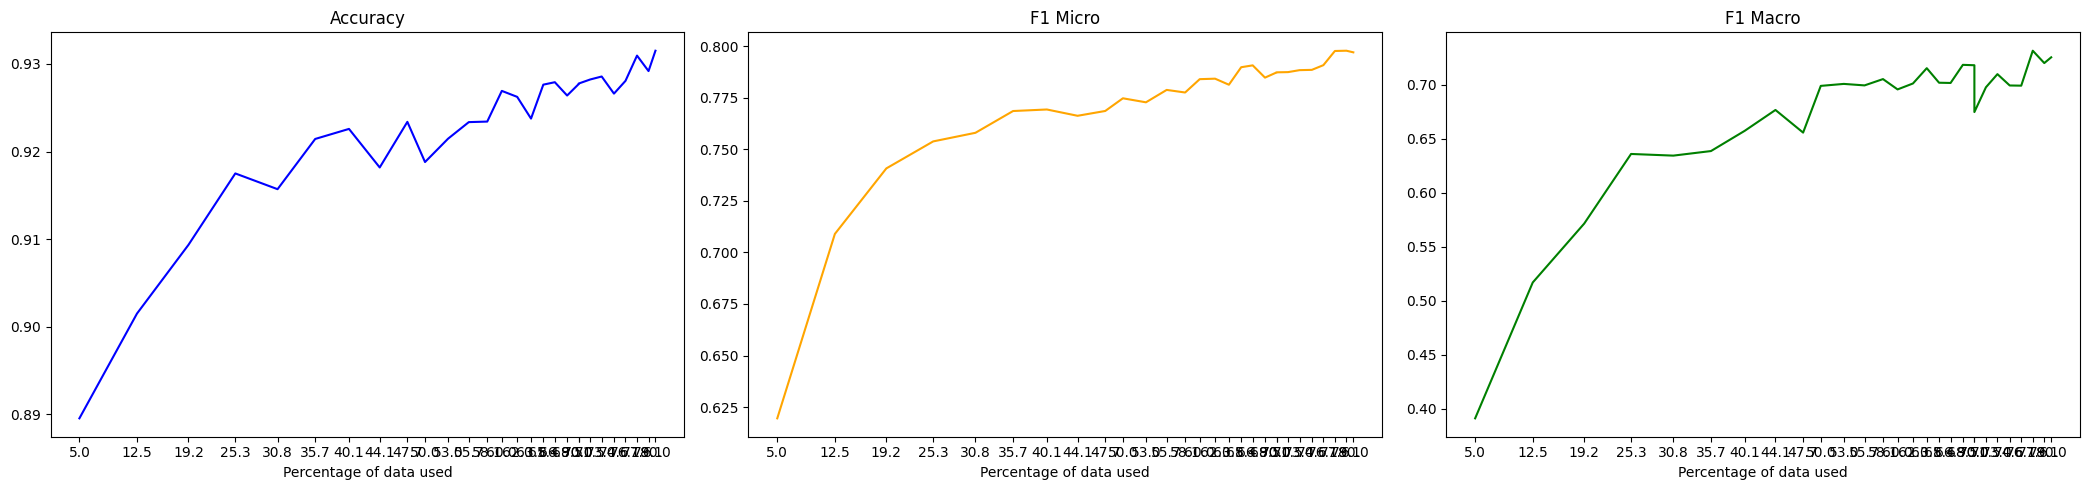

In [25]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.828, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.8342, F1 Micro: 0.1087, F1 Macro: 0.0403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3709, Accuracy: 0.8448, F1 Micro: 0.2599, F1 Macro: 0.0878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3484, Accuracy: 0.8632, F1 Micro: 0.4852, F1 Macro: 0.2064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3341, Accuracy: 0.8732, F1 Micro: 0.5834, F1 Macro: 0.2692
Epoch 6/10, Train Loss: 0.2942, Accuracy: 0.8779, F1 Micro: 0.5622, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2602, Accuracy: 0.8819, F1 Micro: 0.5948, F1 Macro: 0.285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2414, Accuracy: 0.8842, F1 Micro: 0.6007, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2191, Accuracy: 0.8873, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4802, Accuracy: 0.8373, F1 Micro: 0.1574, F1 Macro: 0.058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3722, Accuracy: 0.8668, F1 Micro: 0.5569, F1 Macro: 0.2518
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.878, F1 Micro: 0.527, F1 Macro: 0.2432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2747, Accuracy: 0.8899, F1 Micro: 0.6101, F1 Macro: 0.3134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2386, Accuracy: 0.8944, F1 Micro: 0.6457, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2087, Accuracy: 0.8999, F1 Micro: 0.686, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1754, Accuracy: 0.9004, F1 Micro: 0.7029, F1 Macro: 0.52
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1531, Accuracy: 0.9011, F1 Micro: 0.7065, F1 Macro: 0.5205
Epoch 9/10, Train Loss: 0.1246, Accuracy: 0.9031, F1 Micro: 0.6889, F1 Macro: 0.5093
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.8494, F1 Micro: 0.3435, F1 Macro: 0.1073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3378, Accuracy: 0.8841, F1 Micro: 0.6019, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.8969, F1 Micro: 0.6669, F1 Macro: 0.3791
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.897, F1 Micro: 0.6256, F1 Macro: 0.3811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1997, Accuracy: 0.9063, F1 Micro: 0.7149, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1683, Accuracy: 0.9052, F1 Micro: 0.7233, F1 Macro: 0.5383
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9077, F1 Micro: 0.7083, F1 Macro: 0.5175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1128, Accuracy: 0.912, F1 Micro: 0.7351, F1 Macro: 0.572
Epoch 9/10, Train Loss: 0.0917, Accuracy: 0.9112, F1 Micro: 0.7297, F1 Macro: 0.5765
Epoch 10/10, Train Loss: 0.0785, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4261, Accuracy: 0.8698, F1 Micro: 0.4695, F1 Macro: 0.204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.8938, F1 Micro: 0.6353, F1 Macro: 0.3361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2478, Accuracy: 0.9034, F1 Micro: 0.6802, F1 Macro: 0.4381
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9048, F1 Micro: 0.6801, F1 Macro: 0.4316
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9097, F1 Micro: 0.692, F1 Macro: 0.5097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.9135, F1 Micro: 0.7297, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9142, F1 Micro: 0.7341, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9147, F1 Micro: 0.7503, F1 Macro: 0.5967
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9149, F1 Micro: 0.7445, F1 Macro: 0.6399
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8764, F1 Micro: 0.5255, F1 Macro: 0.2438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.8961, F1 Micro: 0.6254, F1 Macro: 0.3633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2293, Accuracy: 0.9087, F1 Micro: 0.7324, F1 Macro: 0.544
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9121, F1 Micro: 0.7188, F1 Macro: 0.5333
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.917, F1 Micro: 0.739, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.914, F1 Micro: 0.7485, F1 Macro: 0.5956
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9167, F1 Micro: 0.7474, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.919, F1 Micro: 0.7497, F1 Macro: 0.616
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9185, F1 Micro: 0.7477, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8814, F1 Micro: 0.5604, F1 Macro: 0.2599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.8995, F1 Micro: 0.6452, F1 Macro: 0.4337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9095, F1 Micro: 0.7065, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9131, F1 Micro: 0.7493, F1 Macro: 0.5682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9176, F1 Micro: 0.7539, F1 Macro: 0.5972
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9158, F1 Micro: 0.731, F1 Macro: 0.5934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9141, F1 Micro: 0.7558, F1 Macro: 0.6456
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9131, F1 Micro: 0.7558, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9172, F1 Micro: 0.7629, F1 Macro: 0.6546
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3845, Accuracy: 0.8836, F1 Micro: 0.5886, F1 Macro: 0.2817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9047, F1 Micro: 0.7006, F1 Macro: 0.4199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9135, F1 Micro: 0.7409, F1 Macro: 0.5491
Epoch 4/10, Train Loss: 0.1729, Accuracy: 0.9152, F1 Micro: 0.7263, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9166, F1 Micro: 0.7576, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9201, F1 Micro: 0.7614, F1 Macro: 0.6578
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9209, F1 Micro: 0.7603, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.92, F1 Micro: 0.7637, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9211, F1 Micro: 0.7677, F1 Macro: 0.6852
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8873, F1 Micro: 0.6368, F1 Macro: 0.314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9061, F1 Micro: 0.7108, F1 Macro: 0.5199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.912, F1 Micro: 0.7464, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9196, F1 Micro: 0.7551, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9214, F1 Micro: 0.7628, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9232, F1 Micro: 0.7651, F1 Macro: 0.6475
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9173, F1 Micro: 0.7648, F1 Macro: 0.6479
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9215, F1 Micro: 0.7613, F1 Macro: 0.6662
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9177, F1 Micro: 0.7625, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8893, F1 Micro: 0.6618, F1 Macro: 0.373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.9084, F1 Micro: 0.7045, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9184, F1 Micro: 0.7496, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9118, F1 Micro: 0.7555, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9228, F1 Micro: 0.7636, F1 Macro: 0.6331
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9194, F1 Micro: 0.7601, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9224, F1 Micro: 0.7681, F1 Macro: 0.662
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9207, F1 Micro: 0.7612, F1 Macro: 0.6751
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9226, F1 Micro: 0.7635, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.8896, F1 Micro: 0.6058, F1 Macro: 0.3039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.911, F1 Micro: 0.7221, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9192, F1 Micro: 0.7536, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9196, F1 Micro: 0.7609, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9224, F1 Micro: 0.7677, F1 Macro: 0.6454
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9221, F1 Micro: 0.7619, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9232, F1 Micro: 0.7713, F1 Macro: 0.6866
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.9233, F1 Micro: 0.7712, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9226, F1 Micro: 0.7724, F1 Macro: 0.6875
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.354, Accuracy: 0.8928, F1 Micro: 0.6177, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9105, F1 Micro: 0.7274, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.92, F1 Micro: 0.75, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9178, F1 Micro: 0.7675, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9236, F1 Micro: 0.7732, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.9258, F1 Micro: 0.7736, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9222, F1 Micro: 0.775, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9249, F1 Micro: 0.7751, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9221, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.8996, F1 Micro: 0.6693, F1 Macro: 0.3715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9137, F1 Micro: 0.7161, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9205, F1 Micro: 0.7599, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9187, F1 Micro: 0.7617, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.92, F1 Micro: 0.7721, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9252, F1 Micro: 0.7777, F1 Macro: 0.666
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9222, F1 Micro: 0.7724, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9269, F1 Micro: 0.7843, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9255, F1 Micro: 0.774, F1 Macro: 0.6984
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3523, Accuracy: 0.8979, F1 Micro: 0.6865, F1 Macro: 0.412
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.912, F1 Micro: 0.733, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.918, F1 Micro: 0.7625, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9221, F1 Micro: 0.7716, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9246, F1 Micro: 0.7784, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9236, F1 Micro: 0.7729, F1 Macro: 0.6719
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9264, F1 Micro: 0.7774, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9241, F1 Micro: 0.7796, F1 Macro: 0.6834
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9217, F1 Micro: 0.7775, F1 Macro: 0.7109
Epoch 10/10, Train Loss: 0.0465, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3519, Accuracy: 0.8996, F1 Micro: 0.6884, F1 Macro: 0.4285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9107, F1 Micro: 0.7397, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9182, F1 Micro: 0.7405, F1 Macro: 0.5811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9211, F1 Micro: 0.7725, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9247, F1 Micro: 0.7838, F1 Macro: 0.6812
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9264, F1 Micro: 0.782, F1 Macro: 0.6921
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9264, F1 Micro: 0.7659, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9275, F1 Micro: 0.7882, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9274, F1 Micro: 0.786, F1 Macro: 0.7115
Epoch 10/10, Train Loss: 0.0484, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3477, Accuracy: 0.9004, F1 Micro: 0.6756, F1 Macro: 0.4078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.9168, F1 Micro: 0.7577, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9217, F1 Micro: 0.7676, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9254, F1 Micro: 0.7794, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9265, F1 Micro: 0.772, F1 Macro: 0.6565
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9216, F1 Micro: 0.779, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9253, F1 Micro: 0.7808, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9249, F1 Micro: 0.7813, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9295, F1 Micro: 0.7886, F1 Macro: 0.7239
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.902, F1 Micro: 0.696, F1 Macro: 0.4492
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.917, F1 Micro: 0.7514, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9219, F1 Micro: 0.7658, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9241, F1 Micro: 0.7798, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9251, F1 Micro: 0.7864, F1 Macro: 0.6882
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9208, F1 Micro: 0.7735, F1 Macro: 0.6716
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9245, F1 Micro: 0.7788, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.928, F1 Micro: 0.7878, F1 Macro: 0.7158
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9263, F1 Micro: 0.7817, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.0455, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.339, Accuracy: 0.9028, F1 Micro: 0.7045, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9183, F1 Micro: 0.7533, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9235, F1 Micro: 0.7723, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9256, F1 Micro: 0.7803, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9264, F1 Micro: 0.7815, F1 Macro: 0.6736
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9242, F1 Micro: 0.7757, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.926, F1 Micro: 0.782, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9245, F1 Micro: 0.7842, F1 Macro: 0.7115
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9252, F1 Micro: 0.7827, F1 Macro: 0.7136
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.9028, F1 Micro: 0.6829, F1 Macro: 0.392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.9187, F1 Micro: 0.7582, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9248, F1 Micro: 0.769, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9228, F1 Micro: 0.7767, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9293, F1 Micro: 0.7893, F1 Macro: 0.6846
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9274, F1 Micro: 0.7865, F1 Macro: 0.6795
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9281, F1 Micro: 0.7809, F1 Macro: 0.6914
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.927, F1 Micro: 0.7803, F1 Macro: 0.7049
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9244, F1 Micro: 0.7855, F1 Macro: 0.7201
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9279, F1 Micro: 0.7816, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9021, F1 Micro: 0.6693, F1 Macro: 0.3878
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.9147, F1 Micro: 0.7208, F1 Macro: 0.5237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9225, F1 Micro: 0.7659, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9256, F1 Micro: 0.779, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9227, F1 Micro: 0.7809, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9284, F1 Micro: 0.7889, F1 Macro: 0.7057
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9286, F1 Micro: 0.7857, F1 Macro: 0.7086
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9293, F1 Micro: 0.7824, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9279, F1 Micro: 0.787, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0438, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3402, Accuracy: 0.9036, F1 Micro: 0.6997, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9178, F1 Micro: 0.7546, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9246, F1 Micro: 0.7728, F1 Macro: 0.6225
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9247, F1 Micro: 0.7598, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9268, F1 Micro: 0.7846, F1 Macro: 0.6844
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.927, F1 Micro: 0.7833, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9241, F1 Micro: 0.7849, F1 Macro: 0.7105
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9244, F1 Micro: 0.7838, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9288, F1 Micro: 0.7858, F1 Macro: 0.7145
Epoch 10/10, Train Loss: 0.0455, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9053, F1 Micro: 0.7113, F1 Macro: 0.4879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9195, F1 Micro: 0.7566, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9256, F1 Micro: 0.7778, F1 Macro: 0.6385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9256, F1 Micro: 0.7845, F1 Macro: 0.6456
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9259, F1 Micro: 0.7837, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9261, F1 Micro: 0.7879, F1 Macro: 0.6959
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9276, F1 Micro: 0.7814, F1 Macro: 0.7082
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9271, F1 Micro: 0.7847, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9292, F1 Micro: 0.7927, F1 Macro: 0.7256
Epoch 10/10, Train Loss: 0.0409, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.9036, F1 Micro: 0.6789, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9187, F1 Micro: 0.7521, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9239, F1 Micro: 0.7697, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9264, F1 Micro: 0.7799, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9273, F1 Micro: 0.7873, F1 Macro: 0.6939
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9257, F1 Micro: 0.7856, F1 Macro: 0.6984
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9274, F1 Micro: 0.7871, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9298, F1 Micro: 0.7889, F1 Macro: 0.7208
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9262, F1 Micro: 0.7839, F1 Macro: 0.7113
Epoch 10/10, Train Loss: 0.0429, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.333, Accuracy: 0.9041, F1 Micro: 0.6985, F1 Macro: 0.4353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.9179, F1 Micro: 0.7509, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9248, F1 Micro: 0.7727, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.926, F1 Micro: 0.7882, F1 Macro: 0.6794
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9267, F1 Micro: 0.7793, F1 Macro: 0.685
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9258, F1 Micro: 0.7852, F1 Macro: 0.6947
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9202, F1 Micro: 0.7787, F1 Macro: 0.7075
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9233, F1 Micro: 0.7808, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9256, F1 Micro: 0.7844, F1 Macro: 0.7188
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9254, F1 Micro: 0.782, F1 Macro: 0.7176

 Iteration 9618: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3311, Accuracy: 0.9065, F1 Micro: 0.7041, F1 Macro: 0.4545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9142, F1 Micro: 0.7095, F1 Macro: 0.5037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9238, F1 Micro: 0.76, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.9293, F1 Micro: 0.7827, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.9275, F1 Micro: 0.7838, F1 Macro: 0.6725
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9269, F1 Micro: 0.7738, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9293, F1 Micro: 0.7866, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.926, F1 Micro: 0.7875, F1 Macro: 0.7218
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9266, F1 Micro: 0.7767, F1 Macro: 0.7008
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9026, F1 Micro: 0.6896, F1 Macro: 0.4086
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.218, Accuracy: 0.9211, F1 Micro: 0.7636, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9248, F1 Micro: 0.7786, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9285, F1 Micro: 0.7787, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9293, F1 Micro: 0.7908, F1 Macro: 0.7003
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9292, F1 Micro: 0.789, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9267, F1 Micro: 0.7907, F1 Macro: 0.7172
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9284, F1 Micro: 0.7866, F1 Macro: 0.7208
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9275, F1 Micro: 0.788, F1 Macro: 0.7203
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9283, F1 Micro: 0.7904, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3284, Accuracy: 0.906, F1 Micro: 0.6911, F1 Macro: 0.4886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9204, F1 Micro: 0.7582, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9263, F1 Micro: 0.7787, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9272, F1 Micro: 0.7887, F1 Macro: 0.6732
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.926, F1 Micro: 0.7794, F1 Macro: 0.6941
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9272, F1 Micro: 0.7876, F1 Macro: 0.7166
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9263, F1 Micro: 0.7838, F1 Macro: 0.7131
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9248, F1 Micro: 0.7814, F1 Macro: 0.7208
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9273, F1 Micro: 0.7833, F1 Macro: 0.715
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.928, F1 Micro: 0.7791, F1 Macro: 0.7145

 Iteration 10218: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9062, F1 Micro: 0.7056, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.918, F1 Micro: 0.7622, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9247, F1 Micro: 0.7656, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9273, F1 Micro: 0.7877, F1 Macro: 0.7
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9262, F1 Micro: 0.7831, F1 Macro: 0.6894
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9291, F1 Micro: 0.7868, F1 Macro: 0.7136
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9251, F1 Micro: 0.7781, F1 Macro: 0.7113
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9257, F1 Micro: 0.7793, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9271, F1 Micro: 0.7823, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.927, F1 Micro: 0.7888, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3276, Accuracy: 0.9078, F1 Micro: 0.7211, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9187, F1 Micro: 0.7661, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9294, F1 Micro: 0.7891, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9248, F1 Micro: 0.7797, F1 Macro: 0.6426
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9273, F1 Micro: 0.7762, F1 Macro: 0.7033
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9289, F1 Micro: 0.788, F1 Macro: 0.7155
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9285, F1 Micro: 0.7881, F1 Macro: 0.716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9269, F1 Micro: 0.7895, F1 Macro: 0.727
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9259, F1 Micro: 0.7804, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0413, Accuracy: 0.9283, F1 Micro: 0.7886, F1 Macro: 0.7236

 Iteration 10535: A

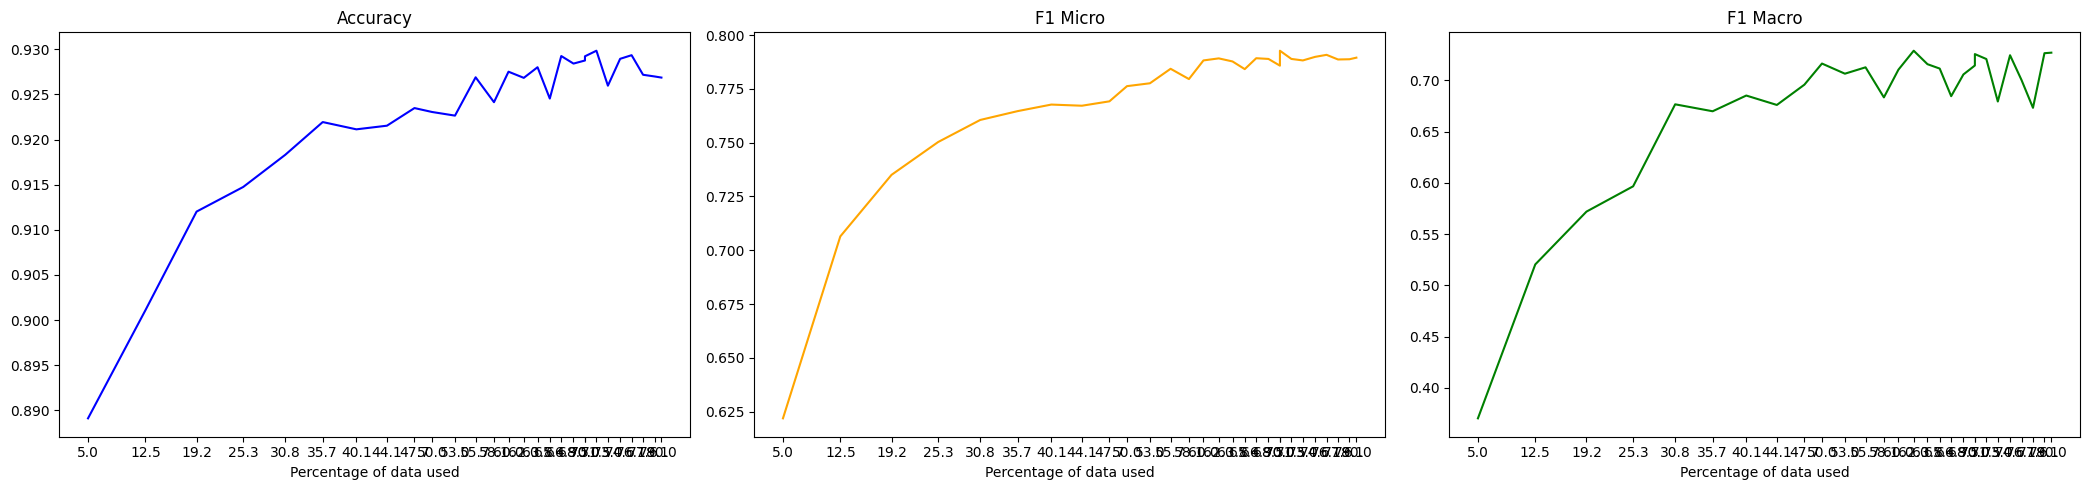

In [26]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5555, Accuracy: 0.8337, F1 Micro: 0.1221, F1 Macro: 0.0455
Epoch 2/10, Train Loss: 0.412, Accuracy: 0.8331, F1 Micro: 0.093, F1 Macro: 0.0357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3838, Accuracy: 0.85, F1 Micro: 0.3324, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.361, Accuracy: 0.8623, F1 Micro: 0.4364, F1 Macro: 0.1744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3354, Accuracy: 0.8743, F1 Micro: 0.5172, F1 Macro: 0.2393
Epoch 6/10, Train Loss: 0.2895, Accuracy: 0.8755, F1 Micro: 0.5149, F1 Macro: 0.2388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2746, Accuracy: 0.8809, F1 Micro: 0.5603, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2369, Accuracy: 0.8823, F1 Micro: 0.5656, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2069, Accuracy: 0.8868, F1 Micro: 0.619, F1 Macro: 0.3533
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4827, Accuracy: 0.8341, F1 Micro: 0.1014, F1 Macro: 0.0393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3764, Accuracy: 0.8668, F1 Micro: 0.4571, F1 Macro: 0.1747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3192, Accuracy: 0.8846, F1 Micro: 0.6116, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2729, Accuracy: 0.8904, F1 Micro: 0.6332, F1 Macro: 0.3692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2333, Accuracy: 0.8934, F1 Micro: 0.6458, F1 Macro: 0.3684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2054, Accuracy: 0.8983, F1 Micro: 0.6769, F1 Macro: 0.4526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1727, Accuracy: 0.8984, F1 Micro: 0.6947, F1 Macro: 0.4888
Epoch 8/10, Train Loss: 0.1444, Accuracy: 0.9009, F1 Micro: 0.6827, F1 Macro: 0.4988
Epoch 9/10, Train Loss: 0.1211, Accuracy: 0.9004, F1 Micro: 0.6922, F1 Macro: 0.5165
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.8484, F1 Micro: 0.2695, F1 Macro: 0.0926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3257, Accuracy: 0.8857, F1 Micro: 0.6195, F1 Macro: 0.3372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2646, Accuracy: 0.8938, F1 Micro: 0.6217, F1 Macro: 0.3831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2311, Accuracy: 0.9027, F1 Micro: 0.7044, F1 Macro: 0.4816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1889, Accuracy: 0.907, F1 Micro: 0.7237, F1 Macro: 0.5309
Epoch 6/10, Train Loss: 0.1577, Accuracy: 0.9068, F1 Micro: 0.6919, F1 Macro: 0.5068
Epoch 7/10, Train Loss: 0.1336, Accuracy: 0.906, F1 Micro: 0.7092, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1084, Accuracy: 0.9096, F1 Micro: 0.7312, F1 Macro: 0.5605
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.91, F1 Micro: 0.7242, F1 Macro: 0.5646
Epoch 10/10, Train Loss: 0.079, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4194, Accuracy: 0.8678, F1 Micro: 0.4565, F1 Macro: 0.1893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.8928, F1 Micro: 0.6461, F1 Macro: 0.3299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.9031, F1 Micro: 0.6891, F1 Macro: 0.4355
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2116, Accuracy: 0.9085, F1 Micro: 0.6974, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9084, F1 Micro: 0.729, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9146, F1 Micro: 0.7415, F1 Macro: 0.5685
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9131, F1 Micro: 0.7393, F1 Macro: 0.587
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.915, F1 Micro: 0.7343, F1 Macro: 0.607
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9137, F1 Micro: 0.7467, F1 Macro: 0.6148
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.879, F1 Micro: 0.5632, F1 Macro: 0.2627
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.8998, F1 Micro: 0.6807, F1 Macro: 0.4074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9096, F1 Micro: 0.722, F1 Macro: 0.5386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9107, F1 Micro: 0.7347, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9144, F1 Micro: 0.7359, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9153, F1 Micro: 0.7409, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1052, Accuracy: 0.9152, F1 Micro: 0.7442, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9122, F1 Micro: 0.7506, F1 Macro: 0.6175
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9117, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3938, Accuracy: 0.882, F1 Micro: 0.585, F1 Macro: 0.2739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9002, F1 Micro: 0.652, F1 Macro: 0.4274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9095, F1 Micro: 0.7164, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9165, F1 Micro: 0.7446, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9155, F1 Micro: 0.7467, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9195, F1 Micro: 0.753, F1 Macro: 0.6015
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9178, F1 Micro: 0.7527, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9176, F1 Micro: 0.7559, F1 Macro: 0.6195
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9179, F1 Micro: 0.7486, F1 Macro: 0.6294
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8865, F1 Micro: 0.6353, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9075, F1 Micro: 0.711, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9126, F1 Micro: 0.7193, F1 Macro: 0.5302
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9164, F1 Micro: 0.7438, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9163, F1 Micro: 0.754, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9192, F1 Micro: 0.7626, F1 Macro: 0.6166
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.917, F1 Micro: 0.7581, F1 Macro: 0.6128
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9168, F1 Micro: 0.7622, F1 Macro: 0.6442
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9168, F1 Micro: 0.7597, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.89, F1 Micro: 0.6537, F1 Macro: 0.3657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2598, Accuracy: 0.9031, F1 Micro: 0.7243, F1 Macro: 0.544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9084, F1 Micro: 0.7448, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9169, F1 Micro: 0.7462, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9195, F1 Micro: 0.7608, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9169, F1 Micro: 0.7616, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9178, F1 Micro: 0.7665, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9221, F1 Micro: 0.7663, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.065, Accuracy: 0.9219, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3685, Accuracy: 0.888, F1 Micro: 0.5941, F1 Macro: 0.3122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9078, F1 Micro: 0.7001, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9172, F1 Micro: 0.7495, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9212, F1 Micro: 0.7597, F1 Macro: 0.6108
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9155, F1 Micro: 0.7534, F1 Macro: 0.6114
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9204, F1 Micro: 0.7595, F1 Macro: 0.6283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9242, F1 Micro: 0.778, F1 Macro: 0.6791
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9228, F1 Micro: 0.7699, F1 Macro: 0.6553
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.924, F1 Micro: 0.7707, F1 Macro: 0.6544
Epoch 10/10, Train Loss: 0.052, Accuracy: 0.9233, F1 Micro: 0.7749, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.364, Accuracy: 0.8932, F1 Micro: 0.6786, F1 Macro: 0.3929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9098, F1 Micro: 0.7225, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9158, F1 Micro: 0.7264, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9197, F1 Micro: 0.7649, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.922, F1 Micro: 0.7706, F1 Macro: 0.6344
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9208, F1 Micro: 0.7601, F1 Macro: 0.6257
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9204, F1 Micro: 0.7505, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9229, F1 Micro: 0.7746, F1 Macro: 0.6805
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9215, F1 Micro: 0.7672, F1 Macro: 0.672
Epoch 10/10, Train Loss: 0.0536, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8942, F1 Micro: 0.6687, F1 Macro: 0.3809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9118, F1 Micro: 0.7153, F1 Macro: 0.516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.918, F1 Micro: 0.7606, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9239, F1 Micro: 0.7708, F1 Macro: 0.6248
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9232, F1 Micro: 0.7687, F1 Macro: 0.6329
Epoch 6/10, Train Loss: 0.1076, Accuracy: 0.9212, F1 Micro: 0.7657, F1 Macro: 0.6479
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.92, F1 Micro: 0.7692, F1 Macro: 0.6449
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9184, F1 Micro: 0.7643, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9225, F1 Micro: 0.7723, F1 Macro: 0.698
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.923, F1 Micro: 0.7692, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3546, Accuracy: 0.8992, F1 Micro: 0.6777, F1 Macro: 0.4324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.9087, F1 Micro: 0.7368, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9179, F1 Micro: 0.7477, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9226, F1 Micro: 0.7743, F1 Macro: 0.6083
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9212, F1 Micro: 0.7732, F1 Macro: 0.6451
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.9232, F1 Micro: 0.7735, F1 Macro: 0.6514
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9234, F1 Micro: 0.7737, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9232, F1 Micro: 0.777, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9248, F1 Micro: 0.7778, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3499, Accuracy: 0.8982, F1 Micro: 0.6872, F1 Macro: 0.3883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9137, F1 Micro: 0.7347, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9213, F1 Micro: 0.7523, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9258, F1 Micro: 0.7745, F1 Macro: 0.6399
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9218, F1 Micro: 0.7656, F1 Macro: 0.6383
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.919, F1 Micro: 0.7681, F1 Macro: 0.6375
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9236, F1 Micro: 0.7777, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9212, F1 Micro: 0.7669, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9183, F1 Micro: 0.7757, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0469, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3447, Accuracy: 0.8945, F1 Micro: 0.6775, F1 Macro: 0.3703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9154, F1 Micro: 0.7398, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9192, F1 Micro: 0.7543, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9247, F1 Micro: 0.7674, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9247, F1 Micro: 0.775, F1 Macro: 0.639
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9202, F1 Micro: 0.7728, F1 Macro: 0.6623
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9236, F1 Micro: 0.767, F1 Macro: 0.6686
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9185, F1 Micro: 0.7699, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9248, F1 Micro: 0.7782, F1 Macro: 0.698
Epoch 10/10, Train Loss: 0.0446, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3387, Accuracy: 0.8987, F1 Micro: 0.6653, F1 Macro: 0.4054
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.9122, F1 Micro: 0.7147, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.924, F1 Micro: 0.7643, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.922, F1 Micro: 0.7726, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9245, F1 Micro: 0.7746, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9234, F1 Micro: 0.7797, F1 Macro: 0.6808
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9254, F1 Micro: 0.7766, F1 Macro: 0.7029
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9222, F1 Micro: 0.7776, F1 Macro: 0.6955
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9237, F1 Micro: 0.7783, F1 Macro: 0.7009
Epoch 10/10, Train Loss: 0.0441, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.9012, F1 Micro: 0.7111, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2308, Accuracy: 0.917, F1 Micro: 0.7433, F1 Macro: 0.5635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9204, F1 Micro: 0.7721, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9221, F1 Micro: 0.7761, F1 Macro: 0.6293
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9238, F1 Micro: 0.7709, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9236, F1 Micro: 0.7774, F1 Macro: 0.6603
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9224, F1 Micro: 0.7673, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9244, F1 Micro: 0.7754, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9235, F1 Micro: 0.7794, F1 Macro: 0.7141
Epoch 10/10, Train Loss: 0.0446, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3416, Accuracy: 0.9005, F1 Micro: 0.67, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2269, Accuracy: 0.9144, F1 Micro: 0.7495, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9216, F1 Micro: 0.7646, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9249, F1 Micro: 0.7771, F1 Macro: 0.6557
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9237, F1 Micro: 0.7763, F1 Macro: 0.6622
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9241, F1 Micro: 0.7717, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9254, F1 Micro: 0.7795, F1 Macro: 0.6964
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9252, F1 Micro: 0.7763, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9271, F1 Micro: 0.7818, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3356, Accuracy: 0.8996, F1 Micro: 0.6891, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.9164, F1 Micro: 0.7503, F1 Macro: 0.5872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9234, F1 Micro: 0.7671, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.923, F1 Micro: 0.7786, F1 Macro: 0.6466
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9253, F1 Micro: 0.7785, F1 Macro: 0.649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9221, F1 Micro: 0.7791, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9271, F1 Micro: 0.7854, F1 Macro: 0.6821
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9266, F1 Micro: 0.7835, F1 Macro: 0.7056
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9284, F1 Micro: 0.784, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3348, Accuracy: 0.9001, F1 Micro: 0.6773, F1 Macro: 0.3905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.9184, F1 Micro: 0.7544, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9231, F1 Micro: 0.7742, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9232, F1 Micro: 0.7792, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.9225, F1 Micro: 0.7808, F1 Macro: 0.6625
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9191, F1 Micro: 0.7736, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.929, F1 Micro: 0.7878, F1 Macro: 0.7047
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9267, F1 Micro: 0.7809, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9274, F1 Micro: 0.7904, F1 Macro: 0.7165
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3387, Accuracy: 0.9023, F1 Micro: 0.6812, F1 Macro: 0.3801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2244, Accuracy: 0.915, F1 Micro: 0.7555, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9255, F1 Micro: 0.7748, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9271, F1 Micro: 0.7762, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9271, F1 Micro: 0.7793, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9244, F1 Micro: 0.7826, F1 Macro: 0.6823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.93, F1 Micro: 0.7845, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9277, F1 Micro: 0.7857, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.8988, F1 Micro: 0.6819, F1 Macro: 0.3713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.226, Accuracy: 0.9159, F1 Micro: 0.7621, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9215, F1 Micro: 0.7663, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9275, F1 Micro: 0.782, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9275, F1 Micro: 0.7836, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9242, F1 Micro: 0.7852, F1 Macro: 0.701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9276, F1 Micro: 0.7867, F1 Macro: 0.7153
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9238, F1 Micro: 0.7806, F1 Macro: 0.7162
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9285, F1 Micro: 0.7813, F1 Macro: 0.7177
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3332, Accuracy: 0.9026, F1 Micro: 0.7146, F1 Macro: 0.5095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2237, Accuracy: 0.9177, F1 Micro: 0.7486, F1 Macro: 0.5462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9234, F1 Micro: 0.7809, F1 Macro: 0.632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9265, F1 Micro: 0.781, F1 Macro: 0.6671
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9272, F1 Micro: 0.7757, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9275, F1 Micro: 0.7817, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9287, F1 Micro: 0.7834, F1 Macro: 0.7061
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9254, F1 Micro: 0.7811, F1 Macro: 0.7101
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9243, F1 Micro: 0.7836, F1 Macro: 0.7194
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3349, Accuracy: 0.9056, F1 Micro: 0.7021, F1 Macro: 0.4618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.92, F1 Micro: 0.7541, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.172, Accuracy: 0.926, F1 Micro: 0.7764, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9279, F1 Micro: 0.7803, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9306, F1 Micro: 0.7869, F1 Macro: 0.6742
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9286, F1 Micro: 0.7834, F1 Macro: 0.6886
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9251, F1 Micro: 0.7862, F1 Macro: 0.7119
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9279, F1 Micro: 0.7846, F1 Macro: 0.7114
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9301, F1 Micro: 0.7929, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9034, F1 Micro: 0.6836, F1 Macro: 0.4163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9155, F1 Micro: 0.7555, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.9213, F1 Micro: 0.7748, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9237, F1 Micro: 0.7818, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9266, F1 Micro: 0.7878, F1 Macro: 0.6922
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.927, F1 Micro: 0.7886, F1 Macro: 0.7002
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9257, F1 Micro: 0.7868, F1 Macro: 0.7116
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9289, F1 Micro: 0.7849, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9256, F1 Micro: 0.7832, F1 Macro: 0.717
Epoch 10/10, Train Loss: 0.0419, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3246, Accuracy: 0.9059, F1 Micro: 0.7031, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2157, Accuracy: 0.9205, F1 Micro: 0.7511, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.924, F1 Micro: 0.7543, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9282, F1 Micro: 0.7821, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9278, F1 Micro: 0.7879, F1 Macro: 0.6682
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9254, F1 Micro: 0.7846, F1 Macro: 0.689
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9272, F1 Micro: 0.781, F1 Macro: 0.6977
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9277, F1 Micro: 0.7809, F1 Macro: 0.7049
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9252, F1 Micro: 0.7831, F1 Macro: 0.7159
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0424, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.9058, F1 Micro: 0.7179, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.9179, F1 Micro: 0.7654, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9258, F1 Micro: 0.7719, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9264, F1 Micro: 0.7807, F1 Macro: 0.6709
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9234, F1 Micro: 0.7776, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.924, F1 Micro: 0.7825, F1 Macro: 0.7039
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9265, F1 Micro: 0.7812, F1 Macro: 0.7132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9283, F1 Micro: 0.7833, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.926, F1 Micro: 0.7836, F1 Macro: 0.7176
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9077, F1 Micro: 0.7105, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9188, F1 Micro: 0.7404, F1 Macro: 0.5704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9257, F1 Micro: 0.7757, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9289, F1 Micro: 0.7895, F1 Macro: 0.6655
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.9223, F1 Micro: 0.7796, F1 Macro: 0.689
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.926, F1 Micro: 0.7876, F1 Macro: 0.7188
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9245, F1 Micro: 0.7831, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9293, F1 Micro: 0.7919, F1 Macro: 0.7252
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9278, F1 Micro: 0.782, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9221, F1 Micro: 0.7812, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3201, Accuracy: 0.9065, F1 Micro: 0.7012, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2148, Accuracy: 0.9173, F1 Micro: 0.7632, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9255, F1 Micro: 0.7748, F1 Macro: 0.6171
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.9196, F1 Micro: 0.7729, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.9263, F1 Micro: 0.7839, F1 Macro: 0.6896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9275, F1 Micro: 0.7891, F1 Macro: 0.705
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9281, F1 Micro: 0.7834, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9292, F1 Micro: 0.7929, F1 Macro: 0.7284
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9222, F1 Micro: 0.78, F1 Macro: 0.7081
Epoch 10/10, Train Loss: 0.0415, Accurac

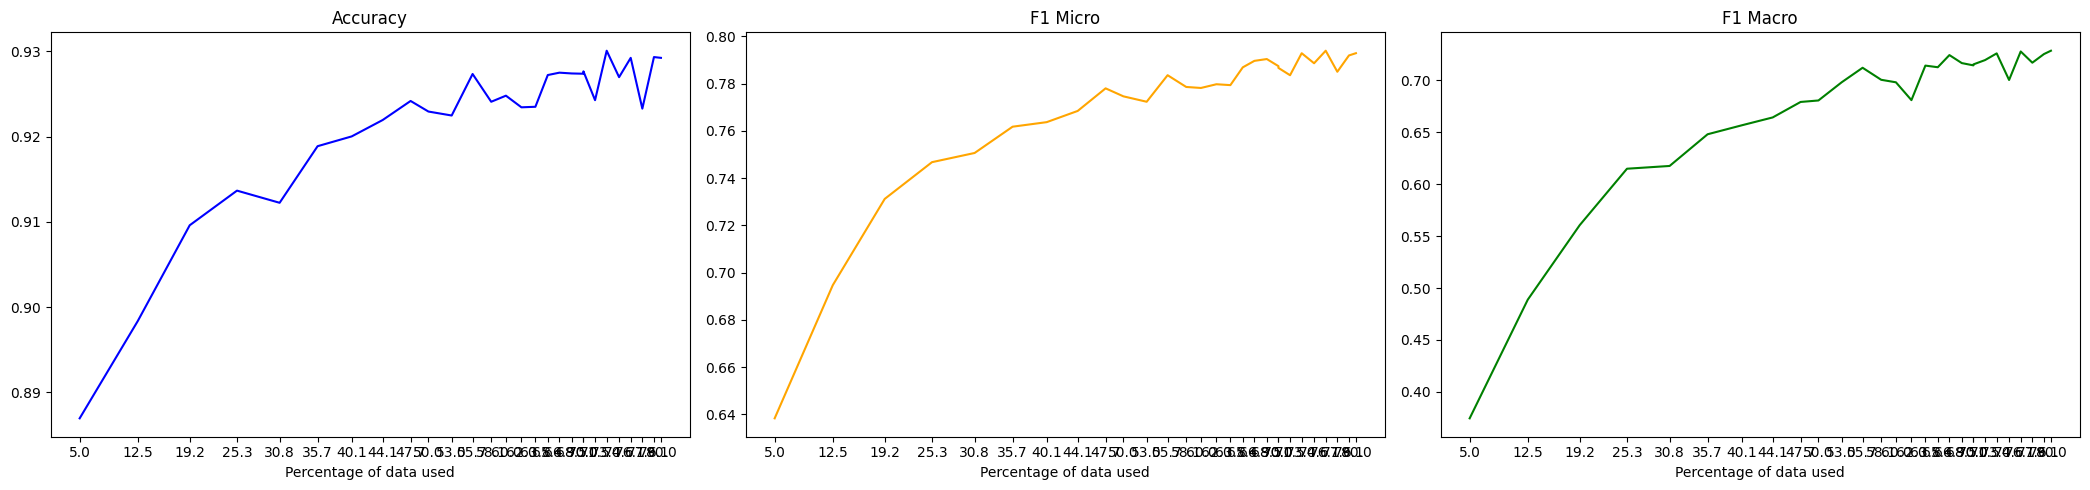

In [27]:
active_learning(seeds[4], 4)